In [ ]:
!pip install --upgrade diffusers transformers scipy ftfy
!pip install flax==0.5.0 --no-deps
!pip install ipywidgets msgpack rich 

# Log in to HuggingFace for access to models

In order to access the models from CompVis for Stable Diffusion, you must follow three steps:

1. You must acknowledge and agree to their user requirements and license for their models. you can do so by reading the instructions found on this page: https://huggingface.co/CompVis/stable-diffusion-v1-4

2. You must login to Huggingface, and then create and retrieve an access token (found here: https://huggingface.co/settings/tokens)

3. Finally, replace the segment of the cell below `<your_huggingface_token>` with your own token, and run the cell. 

If you follow these steps, you will be able to access the model for free!



In [ ]:
!wget https://raw.githubusercontent.com/gradient-ai/stable-diffusion/main/login.py
!python login.py --token <your_huggingface_token>

In [4]:
!mkdir outputs

# Inference

In order to generate an image, you simply need to run one of the two cells below. The first cell is optimized for low power GPUs, like the Free GPU M4000, and will be able to generate an image on any GPU powered Gradient Machine. 

The next cell, is optimized to run on more powerful GPU setups, like an A100 or A6000, and can be used to quickly generate high quality images on these machines. 

In [23]:
# Low cost image generation - works on Free GPU!

# import torch
# from torch import autocast
# from diffusers import StableDiffusionPipeline

# model_id = "CompVis/stable-diffusion-v1-4"
# device = "cuda"
# pipe = StableDiffusionPipeline.from_pretrained(
#     model_id, torch_dtype=torch.float16, revision="fp16", use_auth_token=True)
# pipe = pipe.to(device)

sample_num = 5
lst = []
prompt = 'a corgi astronaut on mars'
for i in range(sample_num):
    with autocast("cuda"):
        lst.append(pipe(prompt, guidance_scale=9.9,height=512, width=512, num_inference_steps = 50, seed = 'random', scheduler = 'LMSDiscreteScheduler')["sample"][0])


for i in range(sample_num):
    lst[i].save(f'outputs/gen-image-{i}.png')


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [92]:
# High cost - FP32

import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)

sample_num = 10
lst = []
prompt = 'a corgi astronaut on mars'
for i in range(sample_num):
    with autocast("cuda"):
        lst.append(pipe(prompt, guidance_scale=7.5)["sample"][0])

    
for i in range(sample_num):
    lst[i].save(f'outputs/gen-image-{i}.png')



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# CLIP reranking

Find the best of your images from the generated samples by ranking them with CLIP by their accuracy to the prompt. 

Code adapted from Boris Dayma's [DALL-E Mini Inference Pipeline](https://github.com/borisdayma/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb) 

In [24]:
from transformers import CLIPProcessor, FlaxCLIPModel
import jax
import jax.numpy as jnp
from flax.jax_utils import replicate
from functools import partial


# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)

# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

In [25]:
from flax.training.common_utils import shard
import numpy as np
# get clip scores
clip_inputs = clip_processor(
    text=prompt * jax.device_count(),
    images=lst,
    return_tensors="np",
    padding="max_length",
    max_length=77,
    truncation=True,
).data
logits = p_clip(shard(clip_inputs), clip_params)

out = list(reversed(sorted(zip(logits[0], lst))))

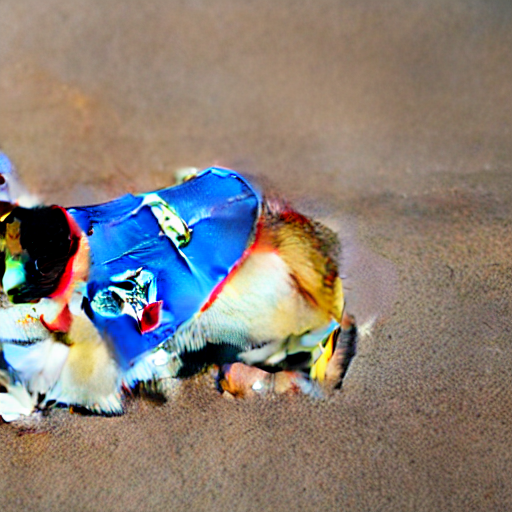

Score: 30.22



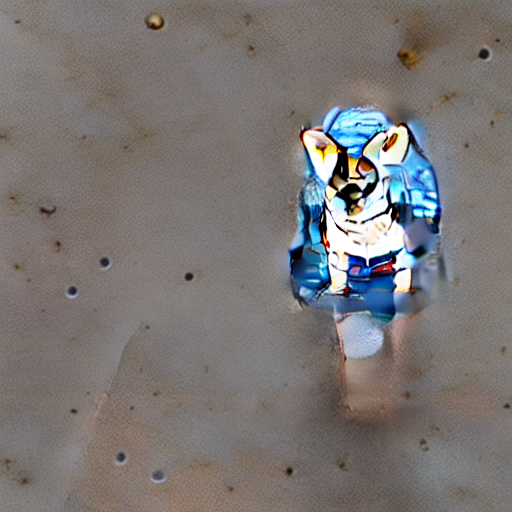

Score: 29.05



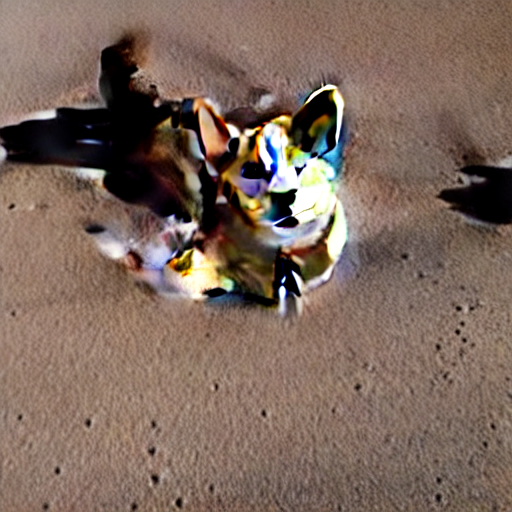

Score: 28.76



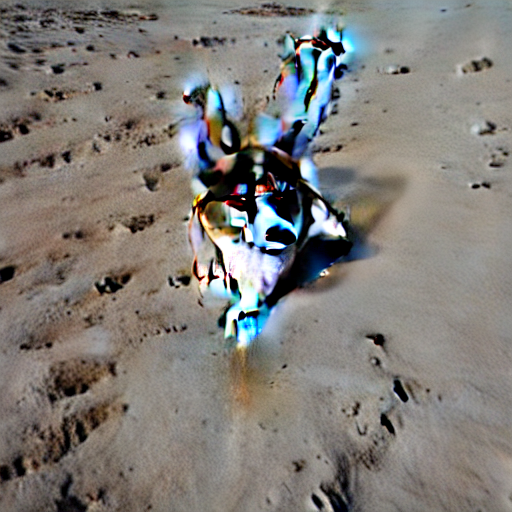

Score: 27.00



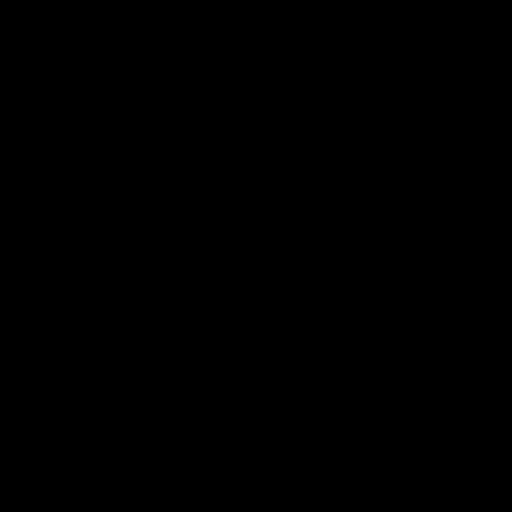

Score: 18.63



In [26]:
for idx, v in enumerate(out):
    display(v[1])
    print(f"Score: {v[0][0]:.2f}\n")
    


# GFPGAN

GFPGAN aims at developing a Practical Algorithm for Real-world Face Restoration. It leverages rich and diverse priors encapsulated in a pretrained face GAN (e.g., StyleGAN2) for blind face restoration. GFPGAN is combined with a suite of other restoration and upscaling models to help make your pictures much clearer and cleaner. 

credit to: https://github.com/TencentARC/GFPGAN

In [ ]:
!pip install realesrgan basicsr optax
!git clone https: // github.com/TencentARC/GFPGAN.git

# %cd GFPGAN
# Install basicsr - https://github.com/xinntao/BasicSR
# We use BasicSR for both training and inference
!pip install basicsr optax
# Install facexlib - https://github.com/xinntao/facexlib
# We use face detection and face restoration helper in the facexlib package
!pip install facexlib

!pip install - r requirements.txt
!python setup.py develop

# If you want to enhance the background (non-face) regions with Real-ESRGAN,
# you also need to install the realesrgan package
!pip install realesrgan

# get model
%cd GFPGAN/experiments/pretrained_models
!wget https: // github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth
%cd ~/../notebooks


In [ ]:
%cd GFPGAN/experiments/pretrained_models
!wget https: // github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth
%cd ~/../notebooks
